In [ ]:
# Multiclass • Cell MC-0 — Imports
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


file_path = "/content/drive/MyDrive/Bootcamp_ML_Data_Science/Capstone_Project/model_with_out_source_data/data_extraction/merged_shuffled_20250822_185836.csv"


In [ ]:
target_col = "Label"
six_attacks = ["SSDP", "Evil_Twin", "Krack", "Deauth", "(Re)Assoc", "RogueAP"]

In [ ]:
# Step 1: peek at the first rows to derive allowed columns
head_df = pd.read_csv(file_path, nrows=5000)
cols = head_df.columns.tolist()
assert target_col in cols, "Target column 'Label' not found!"
head_df.head()

In [ ]:
allow_prefixes = ("frame.", "radiotap.", "wlan.", "wlan_radio.")
block_exact = set([
    "frame.number", "frame.time", "frame.time_epoch",
    "radiotap.mactime", "radiotap.present.tsft", "radiotap.timestamp.ts",
    "wlan.bssid","wlan.da","wlan.ra","wlan.sa","wlan.ta","wlan.ssid","wlan.tag","wlan.tag.length",
    "wlan.analysis.kck","wlan.analysis.kek","wlan.rsn.ie.gtk.key","wlan.rsn.ie.igtk.key","wlan.rsn.ie.pmkid",
    "wlan.fixed.timestamp","wlan_rsna_eapol.keydes.msgnr","wlan_rsna_eapol.keydes.data",
    "wlan_rsna_eapol.keydes.data_len","wlan_rsna_eapol.keydes.key_info.key_mic","wlan_rsna_eapol.keydes.nonce",
])

block_patterns = [
    r"(?i)\b(bssid|ssid|mac|addr|oui|vendor|station|ra|ta|sa|da)\b",
    r"(?i)^(ip\.|ipv6\.|arp|tcp\.|udp\.|dns|http|json|ssh|tls|smb2?|nbns|nbss|ldap|dhcp|mdns|ssdp)\b",
    r"(?i)(payload|data\.data|llc|eapol|key|nonce|pmkid|gtk|igtk|kck|kek)",
    r"(?i)(pcap|source_file|capture|interface)",
    r"(?i)(start_tsf|end_tsf|timestamp)",
]

def allowed(col: str) -> bool:
    if col == target_col:
        return True
    low = col.lower()
    if not low.startswith(allow_prefixes):
        return False
    if col in block_exact:
        return False
    for pat in block_patterns:
        if re.search(pat, low):
            return False
    return True

In [ ]:
# Step 2: compute keep_cols and load full dataset with only those columns
keep_cols = [c for c in cols if allowed(c)]
if target_col not in keep_cols:
    keep_cols.append(target_col)

print("Number of columns before filtering:", len(cols), "| after filtering:", len(keep_cols))
print("First 30 kept columns:", keep_cols[:30])



Number of columns before filtering: 255 | after filtering: 39
First 30 kept columns: ['frame.encap_type', 'frame.len', 'frame.time_delta', 'frame.time_delta_displayed', 'frame.time_relative', 'radiotap.channel.flags.cck', 'radiotap.channel.flags.ofdm', 'radiotap.channel.freq', 'radiotap.datarate', 'radiotap.dbm_antsignal', 'radiotap.length', 'radiotap.rxflags', 'radiotap.vendor_oui', 'wlan.duration', 'wlan.country_info.fnm', 'wlan.country_info.code', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.order', 'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.fc.pwrmgt', 'wlan.fc.type', 'wlan.fc.retry', 'wlan.fc.subtype', 'wlan.fcs.bad_checksum', 'wlan.fixed.beacon', 'wlan.fixed.capabilities.ess', 'wlan.fixed.capabilities.ibss', 'wlan.fixed.reason_code']


In [ ]:
df = pd.read_csv(file_path, usecols=keep_cols)
df.replace("?", np.nan, inplace=True)

/tmp/ipython-input-221948936.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=keep_cols)


In [ ]:
df.head(2)

,frame.encap_type,frame.len,frame.time_delta,frame.time_delta_displayed,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,...,wlan.fixed.reason_code,wlan_radio.duration,wlan.seq,wlan_radio.channel,wlan_radio.data_rate,wlan_radio.frequency,wlan_radio.signal_dbm,wlan_radio.phy,wlan.rsn.capabilities.mfpc,Label
0,23,1292,0.000253,0.000253,580.225719,0,1,5180,NaN,-113,...,NaN,103,2972.0,36,156.000,5180,-36,8,NaN,Normal
1,23,1610,0.000001,0.000001,580.511003,0,1,5180,NaN,-103,...,NaN,111,840.0,36,173.333,5180,-33,8,NaN,Normal


In [ ]:
# Step 3: keep only the six attacks (drop Normal and others)
df_mc = df[df[target_col].isin(six_attacks)].copy()

In [ ]:
# Map labels to 0..5 in fixed order
class_order = six_attacks
class_to_id = {lbl: i for i, lbl in enumerate(class_order)}
id_to_class = {i: lbl for lbl, i in class_to_id.items()}

In [ ]:
y_mc = df_mc[target_col].map(class_to_id).astype(int)
feature_cols = [c for c in df_mc.columns if c != target_col]
X_mc = df_mc[feature_cols].copy()

In [ ]:
X_mc.head(5)

,frame.encap_type,frame.len,frame.time_delta,frame.time_delta_displayed,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,...,wlan.fixed.capabilities.ibss,wlan.fixed.reason_code,wlan_radio.duration,wlan.seq,wlan_radio.channel,wlan_radio.data_rate,wlan_radio.frequency,wlan_radio.signal_dbm,wlan_radio.phy,wlan.rsn.capabilities.mfpc
8,23,240,0.000002,0.000002,509.633031,0,1,5180,NaN,-168,...,NaN,NaN,49,2587.0,36,156.000,5180,-56,8,NaN
12,23,240,0.000001,0.000001,510.286331,0,1,5180,NaN,-171,...,NaN,NaN,49,3094.0,36,156.000,5180,-57,8,NaN
13,23,1602,0.001802,0.001802,556.347534,0,1,5180,NaN,-132,...,NaN,NaN,276,2292.0,36,52.000,5180,-44,8,NaN
16,23,240,0.000002,0.000002,510.015786,0,1,5180,NaN,-171,...,NaN,NaN,52,954.0,36,117.000,5180,-57,8,NaN
30,23,240,0.000001,0.000001,510.371090,0,1,5180,NaN,-171,...,NaN,NaN,48,1507.0,36,173.333,5180,-57,8,NaN


In [ ]:
y_mc[y_mc == 3]

,Label
171,3
2160,3
2363,3
2455,3
2556,3
...,...
577357,3
578079,3
578091,3
578152,3


In [ ]:
print("\nMulticlass overall counts:")
print(y_mc.value_counts().sort_index().rename(index=id_to_class))
print("\nClass mapping:", class_to_id)


Multiclass overall counts:
Label
SSDP         40665
Evil_Twin    22201
Krack         5327
Deauth        1011
(Re)Assoc      389
RogueAP        117
Name: count, dtype: int64

Class mapping: {'SSDP': 0, 'Evil_Twin': 1, 'Krack': 2, 'Deauth': 3, '(Re)Assoc': 4, 'RogueAP': 5}


In [ ]:
# Multiclass • Cell MC-2 — Train/test split + type coercion (same logic as binary)

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

# 1) Stratified split
X_mc_tr, X_mc_te, y_mc_tr, y_mc_te = train_test_split(
    X_mc, y_mc, test_size=0.2, random_state=42, stratify=y_mc
)
print("Shapes after split →",
      "X_mc_tr:", X_mc_tr.shape, "X_mc_te:", X_mc_te.shape,
      "y_mc_tr:", y_mc_tr.shape, "y_mc_te:", y_mc_te.shape)

# 2) Coerce mixed columns: convert mostly-numeric text (incl. hex) to float; keep others as categorical strings
def coerce_mixed_columns(df_train, df_test, hex_ok=True, thresh=0.8):
    df_train = df_train.copy()
    df_test  = df_test.copy()
    num_cols, cat_cols = [], []
    for c in df_train.columns:
        s_tr, s_te = df_train[c], df_test[c]
        if s_tr.dtype == object or str(s_tr.dtype).startswith("string"):
            st_tr = s_tr.astype(str)
            if hex_ok:
                st_tr_num = pd.to_numeric(st_tr.str.replace(r"^\s*0x", "", regex=True), errors="coerce")
            else:
                st_tr_num = pd.to_numeric(st_tr, errors="coerce")
            if st_tr_num.notna().mean() >= thresh:
                st_te = s_te.astype(str)
                st_te_num = pd.to_numeric(st_te.str.replace(r"^\s*0x", "", regex=True), errors="coerce")
                df_train[c] = st_tr_num.astype("float32")
                df_test[c]  = st_te_num.astype("float32")
                num_cols.append(c)
            else:
                df_train[c] = st_tr.astype("string")
                df_test[c]  = s_te.astype("string")
                cat_cols.append(c)
        else:
            num_cols.append(c)
    return df_train, df_test, num_cols, cat_cols

X_mc_tr, X_mc_te, num_cols_mc, cat_cols_mc = coerce_mixed_columns(
    X_mc_tr, X_mc_te, hex_ok=True, thresh=0.8
)

print("After coercion → numeric:", len(num_cols_mc), "categorical:", len(cat_cols_mc))


Shapes after split → X_mc_tr: (55768, 38) X_mc_te: (13942, 38) y_mc_tr: (55768,) y_mc_te: (13942,)
After coercion → numeric: 36 categorical: 2


In [ ]:
# Multiclass • Cell MC-3 — Remove columns with >98% NaNs in TRAIN and mirror on TEST

na_ratio_mc = X_mc_tr.isna().mean()
drop_almost_mc = na_ratio_mc[na_ratio_mc > 0.98].index.tolist()

if drop_almost_mc:
    X_mc_tr.drop(columns=drop_almost_mc, inplace=True, errors="ignore")
    X_mc_te.drop(columns=[c for c in drop_almost_mc if c in X_mc_te.columns], inplace=True, errors="ignore")
    num_cols_mc = [c for c in num_cols_mc if c not in drop_almost_mc]
    cat_cols_mc = [c for c in cat_cols_mc if c not in drop_almost_mc]

print("Dropped (almost-all-NaN) columns:", drop_almost_mc)
print("Shapes now → X_mc_tr:", X_mc_tr.shape, "X_mc_te:", X_mc_te.shape)
print("Column groups → numeric:", len(num_cols_mc), "categorical:", len(cat_cols_mc))


Dropped (almost-all-NaN) columns: ['radiotap.vendor_oui', 'wlan.fcs.bad_checksum', 'wlan.fixed.beacon', 'wlan.fixed.capabilities.ess', 'wlan.fixed.capabilities.ibss', 'wlan.fixed.reason_code', 'wlan.rsn.capabilities.mfpc']
Shapes now → X_mc_tr: (55768, 31) X_mc_te: (13942, 31)
Column groups → numeric: 29 categorical: 2


In [ ]:
print(f"X train shape:{X_mc_tr.shape}")
print(f"Y train shape:{y_mc_tr.shape}")

print(f"X test shape:{X_mc_te.shape}")
print(f"Y test shape:{y_mc_te.shape}")

X train shape:(55768, 31)
Y train shape:(55768,)
X test shape:(13942, 31)
Y test shape:(13942,)


In [ ]:
# Cell PRE-5b — Inspect columns with missing values
null_counts = X_mc_tr.isna().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

print("Features with missing values (train):")
print(null_counts)

print("\nTotal columns with nulls:", len(null_counts))


Features with missing values (train):
radiotap.datarate    50354
wlan.seq              1172
dtype: int64

Total columns with nulls: 2


In [ ]:
# Multiclass • Cell MC-4 — Impute + Standardize numerics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

num_imputer_mc = SimpleImputer(strategy="median")

if num_cols_mc:
    X_mc_tr_num = pd.DataFrame(
        num_imputer_mc.fit_transform(X_mc_tr[num_cols_mc]),
        columns=num_cols_mc, index=X_mc_tr.index
    )
    X_mc_te_num = pd.DataFrame(
        num_imputer_mc.transform(X_mc_te[num_cols_mc]),
        columns=num_cols_mc, index=X_mc_te.index
    )
else:
    X_mc_tr_num = pd.DataFrame(index=X_mc_tr.index)
    X_mc_te_num = pd.DataFrame(index=X_mc_te.index)

scaler_mc = StandardScaler(with_mean=True, with_std=True)

if num_cols_mc:
    X_mc_tr_num_scaled = pd.DataFrame(
        scaler_mc.fit_transform(X_mc_tr_num),
        columns=num_cols_mc, index=X_mc_tr.index
    )
    X_mc_te_num_scaled = pd.DataFrame(
        scaler_mc.transform(X_mc_te_num),
        columns=num_cols_mc, index=X_mc_te.index
    )
else:
    X_mc_tr_num_scaled = X_mc_tr_num.copy()
    X_mc_te_num_scaled = X_mc_te_num.copy()

print("Numeric (imputed, standardized) shapes:",
      X_mc_tr_num_scaled.shape, X_mc_te_num_scaled.shape)


Numeric (imputed, standardized) shapes: (55768, 29) (13942, 29)


In [ ]:
# Multiclass • Cell MC-5 — Align categoricals + final feature frames
import pandas as pd

def _align_cats(tr: pd.Series, te: pd.Series, na_token="__NA__"):
    tr = tr.astype("string").fillna(na_token)
    te = te.astype("string").fillna(na_token)
    cats = pd.Index(sorted(pd.unique(pd.concat([tr, te], ignore_index=True))), name=tr.name)
    tr = tr.astype(pd.CategoricalDtype(categories=cats, ordered=False))
    te = te.astype(pd.CategoricalDtype(categories=cats, ordered=False))
    return tr, te

cat_tr_list, cat_te_list = [], []
for c in cat_cols_mc:
    s_tr, s_te = _align_cats(X_mc_tr[c], X_mc_te[c])
    cat_tr_list.append(s_tr.to_frame())
    cat_te_list.append(s_te.to_frame())

X_mc_tr_cat = pd.concat(cat_tr_list, axis=1) if cat_tr_list else pd.DataFrame(index=X_mc_tr.index)
X_mc_te_cat = pd.concat(cat_te_list, axis=1) if cat_te_list else pd.DataFrame(index=X_mc_te.index)

X_mc_tr_pre = pd.concat([X_mc_tr_num_scaled, X_mc_tr_cat], axis=1)
X_mc_te_pre = pd.concat([X_mc_te_num_scaled, X_mc_te_cat], axis=1)

print("Final preprocessed shapes →",
      "X_mc_tr_pre:", X_mc_tr_pre.shape, "| X_mc_te_pre:", X_mc_te_pre.shape)
print("Any NaNs left? train:", X_mc_tr_pre.isna().any().any(),
      "| test:", X_mc_te_pre.isna().any().any())


Final preprocessed shapes → X_mc_tr_pre: (55768, 31) | X_mc_te_pre: (13942, 31)
Any NaNs left? train: False | test: False


Exactly ✅ You’ve got it right.

Here’s what’s happening and what you should do for your **multiclass (6 attacks)** training:

---

### Why keep the raw counts

* **Big classes (SSDP \~40k, Evil\_Twin \~22k)** → they provide real diversity and patterns. If you cut them down to balance, you throw away valuable information.
* **Small classes (RogueAP = 117, (Re)Assoc = 389)** → they’d get drowned out if you trained naively.

So we **keep all data** and instead make the rare classes *“speak louder”* using **class weights**.

---

### How the weights work

The formula:

$$
w_c = \frac{N}{k \cdot n_c}
$$

* $N$ = total samples (69,710 in your dataset)
* $k$ = number of classes (6)
* $n_c$ = samples in class $c$

This gives a weight inversely proportional to frequency.

So in your case:

| Class      | Count  | Weight |
| ---------- | ------ | ------ |
| SSDP       | 40,665 | 0.29   |
| Evil\_Twin | 22,201 | 0.52   |
| Krack      | 5,327  | 2.18   |
| Deauth     | 1,011  | 11.5   |
| (Re)Assoc  | 389    | 29.8   |
| RogueAP    | 117    | 99.2   |

👉 This means: during training, misclassifying **1 RogueAP** is penalized as much as \~340 SSDPs.

---

### How to use in LightGBM

You pass these weights as `class_weight`:

```python
# Build class weights dictionary
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_mc)
weights = {cls: 69710 / (len(classes) * (y_mc == cls).sum()) for cls in classes}
print("Class weights:", weights)

# LightGBM params
params_mc = {
    "objective": "multiclass",
    "num_class": len(classes),
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1,
    "class_weight": weights  # <--- important
}
```

---

### Best practice for evaluation

* Don’t trust **accuracy** (it will just be dominated by SSDP/Evil\_Twin).
* Use **macro-F1** and **per-class recall** to check if small attacks are being recognized.

---

✅ So:

* **Keep your real counts** (don’t flatten everything to 15k).
* **Use class weights** like above.
* **Report per-class metrics** so you can show you’re not ignoring RogueAP & (Re)Assoc.

---

Do you want me to now write you the **LightGBM training + evaluation cells (multiclass, with weights)** so you can run it directly?


In [ ]:
# Build class weights dictionary
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_mc)
weights = {cls: 69710 / (len(classes) * (y_mc == cls).sum()) for cls in classes}
print("Class weights:", weights)

# LightGBM params
params_mc = {
    "objective": "multiclass",
    "num_class": len(classes),
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1,
    "class_weight": weights  # <--- important
}


Class weights: {np.int64(0): np.float64(0.28570843067338825), np.int64(1): np.float64(0.5233247751602781), np.int64(2): np.float64(2.1810274701207684), np.int64(3): np.float64(11.491922189251566), np.int64(4): np.float64(29.867180805484146), np.int64(5): np.float64(99.3019943019943)}


In [ ]:
# Multiclass • Cell MC-LGB-Train — Train LightGBM with class weights

# Requirements:
# - X_mc_tr_pre, X_mc_te_pre (from MC-5)
# - y_mc_tr, y_mc_te (ints 0..5)
# - class_order, id_to_class (from MC-1)
# - num_imputer_mc, scaler_mc kept for later saving if you want

import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# 1) Build class weights: w_c = N / (k * n_c)
classes = np.unique(y_mc_tr)
N = len(y_mc_tr)
k = len(classes)
counts = np.bincount(y_mc_tr, minlength=k)
class_weights = {c: (N / (k * counts[c])) for c in classes}
print("Class weights:", {int(k): float(v) for k, v in class_weights.items()})

# 2) Row-wise weights for the training set
row_weights = np.array([class_weights[int(c)] for c in y_mc_tr])

# 3) Categorical feature names (dtype 'category')
cat_cols_in_pre = [c for c in X_mc_tr_pre.columns if str(X_mc_tr_pre[c].dtype) == "category"]
print("Categorical columns:", cat_cols_in_pre)

# 4) LightGBM datasets
lgb_train = lgb.Dataset(
    X_mc_tr_pre, label=y_mc_tr,
    weight=row_weights,
    categorical_feature=cat_cols_in_pre,
    free_raw_data=False
)
lgb_valid = lgb.Dataset(
    X_mc_te_pre, label=y_mc_te,
    categorical_feature=cat_cols_in_pre,
    reference=lgb_train,
    free_raw_data=False
)

# 5) Params + train
params_mc = {
    "objective": "multiclass",
    "num_class": len(classes),
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.05,
    "num_leaves": 96,
    "min_data_in_leaf": 40,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1,
}


Class weights: {0: 0.28570843067338825, 1: 0.5233188821950716, 2: 2.180822774910058, 3: 11.489081170168934, 4: 29.886387995712756, 5: 99.94265232974911}
Categorical columns: ['wlan.country_info.fnm', 'wlan.country_info.code']


# LightGBM model

In [ ]:
model_mc = lgb.train(
    params_mc,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    num_boost_round=1500,
    callbacks=[
        early_stopping(stopping_rounds=100, verbose=True),
        log_evaluation(period=50),
    ],
)

best_iter_mc = model_mc.best_iteration or model_mc.current_iteration()
print("Best iteration:", best_iter_mc)

Training until validation scores don't improve for 100 rounds
[50]	train's multi_logloss: 0.0215699	train's multi_error: 0.000178293	valid's multi_logloss: 0.0225352	valid's multi_error: 7.17257e-05
[100]	train's multi_logloss: 0.000628253	train's multi_error: 4.69193e-05	valid's multi_logloss: 0.000763104	valid's multi_error: 7.17257e-05
[150]	train's multi_logloss: 0.000107808	train's multi_error: 0	valid's multi_logloss: 0.000178655	valid's multi_error: 0
[200]	train's multi_logloss: 4.89327e-05	train's multi_error: 0	valid's multi_logloss: 9.79687e-05	valid's multi_error: 0
Early stopping, best iteration is:
[116]	train's multi_logloss: 0.000295234	train's multi_error: 0	valid's multi_logloss: 0.000402234	valid's multi_error: 0
Best iteration: 116


In [ ]:
# Multiclass • Cell MC-LGB-Eval — Metrics, confusion matrix, top features

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1) Predictions
proba = model_mc.predict(X_mc_te_pre, num_iteration=best_iter_mc)  # shape (n, K)
y_mc_pred = np.argmax(proba, axis=1)

# 2) Text metrics
print("\nClassification report (per-class):")
print(classification_report(y_mc_te, y_mc_pred, target_names=class_order, digits=4))




Classification report (per-class):
              precision    recall  f1-score   support

        SSDP     1.0000    1.0000    1.0000      8133
   Evil_Twin     1.0000    1.0000    1.0000      4440
       Krack     1.0000    1.0000    1.0000      1065
      Deauth     1.0000    1.0000    1.0000       202
   (Re)Assoc     1.0000    1.0000    1.0000        78
     RogueAP     1.0000    1.0000    1.0000        24

    accuracy                         1.0000     13942
   macro avg     1.0000    1.0000    1.0000     13942
weighted avg     1.0000    1.0000    1.0000     13942



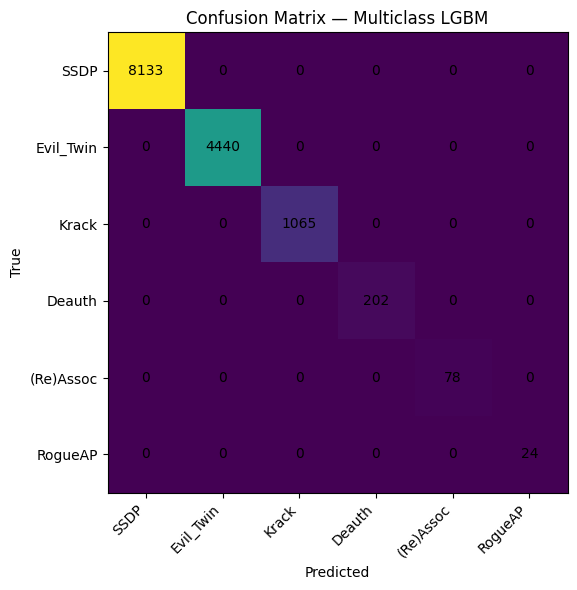


Top 31 features (by gain):
 1. radiotap.channel.freq                    299264.86
 2. frame.time_relative                      275824.19
 3. wlan.country_info.fnm                    256712.92
 4. frame.len                                207263.60
 5. wlan.fc.ds                               138596.09
 6. wlan.seq                                 113558.46
 7. radiotap.dbm_antsignal                   98655.71
 8. wlan.fc.subtype                          79021.87
 9. wlan_radio.duration                      33130.65
10. wlan.fc.type                             31786.64
11. radiotap.datarate                        28523.56
12. wlan.fc.protected                        25086.84
13. wlan.duration                            19893.20
14. wlan_radio.channel                       19586.14
15. radiotap.length                          11163.65
16. wlan.country_info.code                   8141.44
17. wlan_radio.frequency                     3879.22
18. radiotap.channel.flags.ofdm              2063.

In [ ]:
# 3) Confusion matrix
cm = confusion_matrix(y_mc_te, y_mc_pred, labels=list(range(len(class_order))))

fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — Multiclass LGBM")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(len(class_order)))
ax.set_yticks(range(len(class_order)))
ax.set_xticklabels(class_order, rotation=45, ha="right")
ax.set_yticklabels(class_order)

# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# 4) Top features (by gain)
importances = model_mc.feature_importance(importance_type="gain")
feat_names = X_mc_tr_pre.columns.tolist()
topk = max(20, len(feat_names))
fi_sorted = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)[:topk]

print(f"\nTop {topk} features (by gain):")
for i, (f, imp) in enumerate(fi_sorted, 1):
    print(f"{i:2d}. {f:40s} {imp:.2f}")

In [ ]:
# Cell DUP-1 — Check duplicates across train/test (content-based row hashes)

import pandas as pd

# Ensure identical column order for a fair comparison
common_cols = [c for c in X_mc_tr_pre.columns if c in X_mc_te_pre.columns]
X_tr_chk = X_mc_tr_pre.reindex(columns=common_cols)
X_te_chk = X_mc_te_pre.reindex(columns=common_cols)

# Convert categoricals to strings and fill NaNs with a stable token
def _normalize(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    for c in df2.columns:
        if str(df2[c].dtype) == "category":
            df2[c] = df2[c].astype("string")
    return df2.fillna("__NA__")

X_tr_norm = _normalize(X_tr_chk)
X_te_norm = _normalize(X_te_chk)

# Content-based hashes for rows
tr_hash = pd.util.hash_pandas_object(X_tr_norm.astype(str).agg('|'.join, axis=1), index=False)
te_hash = pd.util.hash_pandas_object(X_te_norm.astype(str).agg('|'.join, axis=1), index=False)

tr_set = set(tr_hash.values)
te_set = set(te_hash.values)

overlap = tr_set.intersection(te_set)

print(f"Train rows: {len(tr_set)} | Test rows: {len(te_set)} | Overlap (identical rows): {len(overlap)}")

# (Optional) show a few overlapping examples, if any
if overlap:
    print("\nSample overlapping rows (up to 5):")
    shown = 0
    te_map = pd.Series(te_hash.values, index=X_mc_te_pre.index)
    tr_map = pd.Series(tr_hash.values, index=X_mc_tr_pre.index)
    for h in list(overlap)[:5]:
        tr_idx = tr_map[tr_map == h].index[0]
        te_idx = te_map[te_map == h].index[0]
        print(f"- train idx {tr_idx} ↔ test idx {te_idx}")


Train rows: 55768 | Test rows: 13942 | Overlap (identical rows): 0


In [ ]:
# Cell CV-1 — 5-Fold Stratified CV (multiclass) with class weights and macro-F1

import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Combine preprocessed train+test for CV (quick check)
X_all_pre = pd.concat([X_mc_tr_pre, X_mc_te_pre], axis=0)
y_all = pd.concat([y_mc_tr, y_mc_te], axis=0)

# Identify categorical columns by dtype
cat_cols_cv = [c for c in X_all_pre.columns if str(X_all_pre[c].dtype) == "category"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_all_pre, y_all), 1):
    X_tr_fold = X_all_pre.iloc[tr_idx]
    y_tr_fold = y_all.iloc[tr_idx].astype(int)
    X_va_fold = X_all_pre.iloc[va_idx]
    y_va_fold = y_all.iloc[va_idx].astype(int)

    # Per-fold class weights: w_c = N / (k * n_c)
    classes = np.unique(y_tr_fold)
    N = len(y_tr_fold)
    k = len(classes)
    counts = np.bincount(y_tr_fold, minlength=k)
    class_weights = {c: (N / (k * counts[c])) for c in classes}
    row_weights = np.array([class_weights[int(c)] for c in y_tr_fold])

    dtrain = lgb.Dataset(
        X_tr_fold, label=y_tr_fold,
        weight=row_weights,
        categorical_feature=cat_cols_cv,
        free_raw_data=False
    )
    dvalid = lgb.Dataset(
        X_va_fold, label=y_va_fold,
        categorical_feature=cat_cols_cv,
        reference=dtrain,
        free_raw_data=False
    )

    params = {
        "objective": "multiclass",
        "num_class": len(classes),
        "metric": ["multi_logloss", "multi_error"],
        "learning_rate": 0.05,
        "num_leaves": 96,
        "min_data_in_leaf": 40,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "lambda_l2": 2.0,
        "verbosity": -1,
    }

    model_cv = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        num_boost_round=1200,
        callbacks=[early_stopping(stopping_rounds=80, verbose=False)]
    )

    best_iter = model_cv.best_iteration or model_cv.current_iteration()
    proba = model_cv.predict(X_va_fold, num_iteration=best_iter)
    y_pred = np.argmax(proba, axis=1)

    f1 = f1_score(y_va_fold, y_pred, average="macro", zero_division=0)
    f1_scores.append(f1)
    print(f"Fold {fold}: macro-F1 = {f1:.4f}")

print("\n5-Fold macro-F1 scores:", np.round(f1_scores, 4))
print(f"Mean ± Std: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


Fold 1: macro-F1 = 1.0000
Fold 2: macro-F1 = 1.0000
Fold 3: macro-F1 = 1.0000
Fold 4: macro-F1 = 1.0000
Fold 5: macro-F1 = 1.0000

5-Fold macro-F1 scores: [1. 1. 1. 1. 1.]
Mean ± Std: 1.0000 ± 0.0000


In [ ]:
# DIAG-1 — Inspect top features by gain (current trained model_mc)
import numpy as np

importances = model_mc.feature_importance(importance_type="gain")
feat_names = X_mc_tr_pre.columns.tolist()
topk = max(20, len(feat_names))
fi_sorted = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)[:topk]

print(f"Top {topk} features (by gain):")
for i, (f, imp) in enumerate(fi_sorted, 1):
    print(f"{i:2d}. {f:40s} {imp:.2f}")


Top 20 features (by gain):
 1. radiotap.channel.freq                    299264.86
 2. frame.time_relative                      275824.19
 3. wlan.country_info.fnm                    256712.92
 4. frame.len                                207263.60
 5. wlan.fc.ds                               138596.09
 6. wlan.seq                                 113558.46
 7. radiotap.dbm_antsignal                   98655.71
 8. wlan.fc.subtype                          79021.87
 9. wlan_radio.duration                      33130.65
10. wlan.fc.type                             31786.64
11. radiotap.datarate                        28523.56
12. wlan.fc.protected                        25086.84
13. wlan.duration                            19893.20
14. wlan_radio.channel                       19586.14
15. radiotap.length                          11163.65
16. wlan.country_info.code                   8141.44
17. wlan_radio.frequency                     3879.22
18. radiotap.channel.flags.ofdm              2063.3

In [ ]:
# DIAG-2 — Shuffle labels, retrain, and evaluate (sanity check)
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import f1_score, classification_report

# 1) Shuffle training labels
rng = np.random.default_rng(42)
y_mc_tr_shuf = pd.Series(rng.permutation(y_mc_tr.values), index=y_mc_tr.index)

# 2) Recompute class weights for shuffled labels
classes = np.unique(y_mc_tr_shuf)
N = len(y_mc_tr_shuf)
k = len(classes)
counts = np.bincount(y_mc_tr_shuf, minlength=k)
class_weights_shuf = {c: (N / (k * counts[c])) for c in classes}
row_weights_shuf = np.array([class_weights_shuf[int(c)] for c in y_mc_tr_shuf])

In [ ]:
# 3) Dataset for LightGBM
cat_cols_in_pre = [c for c in X_mc_tr_pre.columns if str(X_mc_tr_pre[c].dtype) == "category"]

dtrain = lgb.Dataset(
    X_mc_tr_pre, label=y_mc_tr_shuf,
    weight=row_weights_shuf,
    categorical_feature=cat_cols_in_pre,
    free_raw_data=False
)
dvalid = lgb.Dataset(
    X_mc_te_pre, label=y_mc_te,   # keep true test labels for evaluation
    categorical_feature=cat_cols_in_pre,
    reference=dtrain,
    free_raw_data=False
)

In [ ]:
params_shuf = {
    "objective": "multiclass",
    "num_class": len(classes),
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 40,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1,
}

model_shuf = lgb.train(
    params_shuf,
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=["train", "valid"],
    num_boost_round=600,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)],
)


In [ ]:
best_iter_shuf = model_shuf.best_iteration or model_shuf.current_iteration()

# 4) Evaluate vs true test labels (should collapse to random performance)
proba_shuf = model_shuf.predict(X_mc_te_pre, num_iteration=best_iter_shuf)
y_pred_shuf = np.argmax(proba_shuf, axis=1)

macro_f1 = f1_score(y_mc_te, y_pred_shuf, average="macro", zero_division=0)
print(f"\nShuffled-label sanity check — macro-F1: {macro_f1:.4f} (random baseline ≈ {1/len(classes):.4f})")

print("\nClassification report (shuffled-label model):")
print(classification_report(y_mc_te, y_pred_shuf, target_names=class_order, digits=4))


Shuffled-label sanity check — macro-F1: 0.1302 (random baseline ≈ 0.1667)

Classification report (shuffled-label model):
              precision    recall  f1-score   support

        SSDP     0.6404    0.2280    0.3362      8133
   Evil_Twin     0.3658    0.1851    0.2459      4440
       Krack     0.1154    0.2582    0.1595      1065
      Deauth     0.0071    0.1040    0.0133       202
   (Re)Assoc     0.0137    0.2949    0.0261        78
     RogueAP     0.0000    0.0000    0.0000        24

    accuracy                         0.2148     13942
   macro avg     0.1904    0.1784    0.1302     13942
weighted avg     0.4991    0.2148    0.2870     13942



---

# DROP-1 — Retrain LightGBM after dropping top 5 "cheat" features


In [ ]:
# DROP-1 — Retrain LightGBM after dropping top 5 "cheat" features

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Top 5 features we identified earlier
drop_feats = [
    "radiotap.channel.freq",
    "frame.time_relative",
    "wlan.country_info.fnm",
    "frame.len",
    "wlan.fc.ds"
]

X_tr_drop = X_mc_tr_pre.drop(columns=[c for c in drop_feats if c in X_mc_tr_pre.columns], errors="ignore")
X_te_drop = X_mc_te_pre.drop(columns=[c for c in drop_feats if c in X_mc_te_pre.columns], errors="ignore")

print("Shapes after dropping features →",
      "X_tr_drop:", X_tr_drop.shape, "| X_te_drop:", X_te_drop.shape)

# Recompute row weights (same as before)
classes = np.unique(y_mc_tr)
N = len(y_mc_tr)
k = len(classes)
counts = np.bincount(y_mc_tr, minlength=k)
class_weights = {c: (N / (k * counts[c])) for c in classes}
row_weights = np.array([class_weights[int(c)] for c in y_mc_tr])

# Categorical columns still present?
cat_cols_in_pre = [c for c in X_tr_drop.columns if str(X_tr_drop[c].dtype) == "category"]

dtrain = lgb.Dataset(
    X_tr_drop, label=y_mc_tr,
    weight=row_weights,
    categorical_feature=cat_cols_in_pre,
    free_raw_data=False
)
dvalid = lgb.Dataset(
    X_te_drop, label=y_mc_te,
    categorical_feature=cat_cols_in_pre,
    reference=dtrain,
    free_raw_data=False
)

params = {
    "objective": "multiclass",
    "num_class": len(classes),
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.05,
    "num_leaves": 96,
    "min_data_in_leaf": 40,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1,
}

model_drop = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=["train", "valid"],
    num_boost_round=1200,
    callbacks=[
        early_stopping(stopping_rounds=80, verbose=False),
        log_evaluation(period=50)
    ]
)

best_iter_drop = model_drop.best_iteration or model_drop.current_iteration()

# Predictions
proba_drop = model_drop.predict(X_te_drop, num_iteration=best_iter_drop)
y_pred_drop = np.argmax(proba_drop, axis=1)

macro_f1_drop = f1_score(y_mc_te, y_pred_drop, average="macro", zero_division=0)

print(f"\nMacro-F1 after dropping top 5 features: {macro_f1_drop:.4f}")
print("\nClassification report (dropped features):")
print(classification_report(y_mc_te, y_pred_drop, target_names=class_order, digits=4))


Shapes after dropping features → X_tr_drop: (55768, 26) | X_te_drop: (13942, 26)
[50]	train's multi_logloss: 0.0219975	train's multi_error: 0.00024398	valid's multi_logloss: 0.271627	valid's multi_error: 0.00573806
[100]	train's multi_logloss: 0.00067116	train's multi_error: 1.87677e-05	valid's multi_logloss: 0.0152403	valid's multi_error: 0.0053077

Macro-F1 after dropping top 5 features: 0.9395

Classification report (dropped features):
              precision    recall  f1-score   support

        SSDP     1.0000    1.0000    1.0000      8133
   Evil_Twin     1.0000    0.9953    0.9976      4440
       Krack     1.0000    1.0000    1.0000      1065
      Deauth     0.9619    1.0000    0.9806       202
   (Re)Assoc     1.0000    0.9103    0.9530        78
     RogueAP     0.5455    1.0000    0.7059        24

    accuracy                         0.9980     13942
   macro avg     0.9179    0.9843    0.9395     13942
weighted avg     0.9987    0.9980    0.9982     13942



In [ ]:
# SAVE-1 — Save LightGBM multiclass model bundle for later inference
from joblib import dump

# Bundle components
bundle_mc = {
    "model": model_mc,
    "best_iteration": int(best_iter_mc),
    "num_imputer": num_imputer_mc,
    "scaler": scaler_mc,
    "num_cols": num_cols_mc,
    "cat_cols": cat_cols_mc,
    "feature_order": X_mc_tr_pre.columns.tolist(),
    "class_order": class_order,
    "id_to_class": id_to_class,
    "class_weights": class_weights
}

dump(bundle_mc, "multiclass_lightgbm_bundle.joblib")
print("✅ Saved model bundle to multiclass_lightgbm_bundle.joblib")


✅ Saved model bundle to multiclass_lightgbm_bundle.joblib
